In [1]:
'''
This notebook loads and analyzes natural video data processed with Gabor filters at three different walking speeds.
Date: 04.11.2024
Author: Jonathan Gant
'''

import numpy as np
import matplotlib.pyplot as plt
import os
from utilities import logistic_func, calc_MI, calc_entropy
from tqdm import tqdm
import h5py
import bottleneck as bn

# Set random seed for reproducibility
np.random.seed(0)

# load in the data
many_speeds_gabor_responses = h5py.File('../results/nat_videos_multi_speed_gabor_responses_full_res_more_low_freq_z_score.h5', 'r')
all_gabor_responses = h5py.File('../results/new_nat_videos_gabor_responses_full_res_more_low_freq_z_score.h5', 'r')

# video size
resolution_height = 1080
resolution_width = 1920

# fov
horizontal_fov = 92
vertical_fov = 61

# conversion factor of pixels to degrees
horizontal_pixels_per_degree = resolution_width / horizontal_fov
vertical_pixels_per_degree = resolution_height / vertical_fov

# average of the conversion factors to the nearest integer
pixels_per_degree = np.ceil((horizontal_pixels_per_degree + vertical_pixels_per_degree) / 2)
print(pixels_per_degree)

# data hyperparameters
orientation_arr = all_gabor_responses['orientation_arr'][()]
phase_arr = all_gabor_responses['phase_arr'][()]
position_arr = all_gabor_responses['position_arr'][()]
wavelength_arr = all_gabor_responses['wavelength_arr'][()]
freq_arr = pixels_per_degree / wavelength_arr
filter_size = (resolution_height, resolution_width)
print(freq_arr)

20.0
[0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09 0.1  0.11 0.12]


In [7]:
environments = ['field', 'forest', 'orchard']

stationary_stim = []
slow_stim = []
medium_stim = []
fast_stim = []

# get the responses for each environment
for env_key in environments:
    all_gabor_responses_env = all_gabor_responses[env_key]
    print(all_gabor_responses_env.keys())
    for vid_key in all_gabor_responses_env.keys():
        if 'stationary' in vid_key:
            stationary_stim.append(all_gabor_responses_env[vid_key][()])
    many_speeds_gabor_responses_env = many_speeds_gabor_responses[env_key]
    for vid_key in many_speeds_gabor_responses_env.keys():
        if 'slow' in vid_key:
            slow_stim.append(many_speeds_gabor_responses_env[vid_key][()])
        if 'medium' in vid_key:
            medium_stim.append(many_speeds_gabor_responses_env[vid_key][()])
        if 'fast' in vid_key:
            fast_stim.append(many_speeds_gabor_responses_env[vid_key][()])

<KeysViewHDF5 ['free_moving_1', 'free_moving_10', 'free_moving_2', 'free_moving_3', 'free_moving_4', 'free_moving_5', 'free_moving_6', 'free_moving_7', 'free_moving_8', 'free_moving_9', 'moving_1', 'moving_10', 'moving_2', 'moving_3', 'moving_4', 'moving_5', 'moving_6', 'moving_7', 'moving_8', 'moving_9', 'stationary_1', 'stationary_10', 'stationary_2', 'stationary_3', 'stationary_4', 'stationary_5', 'stationary_6', 'stationary_7', 'stationary_8', 'stationary_9']>
<KeysViewHDF5 ['free_moving_1', 'free_moving_10', 'free_moving_2', 'free_moving_3', 'free_moving_4', 'free_moving_5', 'free_moving_6', 'free_moving_7', 'free_moving_8', 'free_moving_9', 'moving_1', 'moving_10', 'moving_2', 'moving_3', 'moving_4', 'moving_5', 'moving_6', 'moving_7', 'moving_8', 'moving_9', 'stationary_1', 'stationary_10', 'stationary_2', 'stationary_3', 'stationary_4', 'stationary_5', 'stationary_6', 'stationary_7', 'stationary_8', 'stationary_9']>
<KeysViewHDF5 ['free_moving_1', 'free_moving_10', 'free_moving

In [8]:
for i in range(len(stationary_stim)-1):
    stationary_stim_arr = np.concatenate((stationary_stim[i], stationary_stim[i+1]), axis=-1)
for i in range(len(slow_stim)-1):
    slow_stim_arr = np.concatenate((slow_stim[i], slow_stim[i+1]), axis=-1)
for i in range(len(medium_stim)-1):
    medium_stim_arr = np.concatenate((medium_stim[i], medium_stim[i+1]), axis=-1)
for i in range(len(fast_stim)-1):
    fast_stim_arr = np.concatenate((fast_stim[i], fast_stim[i+1]), axis=-1)

In [9]:
# compute the moving SD of each of the stimuli

import bottleneck as bn

fps = 30
window_length = 5 # seconds
window_size = int(window_length * fps)

windowed_std_stationary_responses = bn.move_std(stationary_stim_arr, window=window_size, min_count=window_size, axis=-1)
windowed_std_slow_responses = bn.move_std(slow_stim_arr, window=window_size, min_count=window_size, axis=-1)
windowed_std_medium_responses = bn.move_std(medium_stim_arr, window=window_size, min_count=window_size, axis=-1)
windowed_std_fast_responses = bn.move_std(fast_stim_arr, window=window_size, min_count=window_size, axis=-1)

In [10]:
windowed_std_slow_responses.shape

(8, 4, 12, 9, 2605)

In [11]:
print(np.nanmean(windowed_std_slow_responses[3, 1, 2, 4, :]))
print(np.nanmean(windowed_std_medium_responses[3, 1, 2, 4, :]))
print(np.nanmean(windowed_std_fast_responses[3, 1, 2, 4, :]))

61.67514819062103
65.89971496647098
68.07937133908135


In [12]:
# optimize nonlinearities using lookup table
dir_name = 'gaussian_optimization_analytic_fast' # 'all_sigma_more_bins_zscored_data'# 'higher_sigma_for_zscored_data' # 'more_sigma_bins_gaussian_results' # 'even_more_sigma_bins_gaussian_results'

MI_arr = np.load(dir_name + '/MI_arr.npy')
# stimulus_entropy = np.load(dir_name + '/stimulus_entropy.npy')
average_response_arr = np.load(dir_name + '/average_response_arr.npy')

# stimulus_bins = np.load(dir_name + '/stimulus_bins.npy') # np.linspace(-30, 30, 200)

# Define the range of k and L values for grid search
k_arr = np.load(dir_name + '/k_arr.npy') # np.logspace(-2, 2, num_bins) # 5*np.logspace(-2, 0, 100)
L_arr = np.load(dir_name + '/L_arr.npy') # np.arange(0.02, 4.02, .02) # np.arange(0.05, 5.05, .05)
sigma_arr = np.load(dir_name + '/sigma_arr.npy') # 5*np.logspace(-2, 1, num_bins) # np.logspace(-2, 2, num_bins)

# for each sigma compute the optimal parameters for a range of different lambdas
lambda_arr = np.arange(0, 2.25, 0.25)
optimal_k = np.zeros((len(sigma_arr), len(lambda_arr)))
optimal_L = np.zeros((len(sigma_arr), len(lambda_arr)))

# import gaussian filter to involve
from scipy.ndimage import gaussian_filter

for i, lambda_ in enumerate(lambda_arr):
    utility = MI_arr - lambda_ * average_response_arr
    print(utility.shape)
    # utility = gaussian_filter(utility, sigma=4, axes=(1, 2))
    for j, sigma in enumerate(sigma_arr):
        optimal_k[j, i] = k_arr[np.unravel_index(np.argmax(utility[j, :, :]), utility[j, :, :].shape)[0]]
        optimal_L[j, i] = L_arr[np.unravel_index(np.argmax(utility[j, :, :]), utility[j, :, :].shape)[1]]

(280, 200, 200)
(280, 200, 200)
(280, 200, 200)
(280, 200, 200)
(280, 200, 200)
(280, 200, 200)
(280, 200, 200)
(280, 200, 200)
(280, 200, 200)


In [13]:
# loop over all orientations and phases and wavelengths and compute the optimal parameters for each
optimal_k_arr_stationary = np.zeros((len(orientation_arr), len(phase_arr), len(wavelength_arr), len(position_arr), len(lambda_arr)))
optimal_L_arr_stationary = np.zeros((len(orientation_arr), len(phase_arr), len(wavelength_arr), len(position_arr), len(lambda_arr)))
optimal_k_arr_slow = np.zeros((len(orientation_arr), len(phase_arr), len(wavelength_arr), len(position_arr), len(lambda_arr)))
optimal_L_arr_slow = np.zeros((len(orientation_arr), len(phase_arr), len(wavelength_arr), len(position_arr), len(lambda_arr)))
optimal_k_arr_medium = np.zeros((len(orientation_arr), len(phase_arr), len(wavelength_arr), len(position_arr), len(lambda_arr)))
optimal_L_arr_medium = np.zeros((len(orientation_arr), len(phase_arr), len(wavelength_arr), len(position_arr), len(lambda_arr)))
optimal_k_arr_fast = np.zeros((len(orientation_arr), len(phase_arr), len(wavelength_arr), len(position_arr), len(lambda_arr)))
optimal_L_arr_fast = np.zeros((len(orientation_arr), len(phase_arr), len(wavelength_arr), len(position_arr), len(lambda_arr)))

for i, orientation in tqdm(enumerate(orientation_arr)):
    print("orientation: " + str(orientation))
    for j, phase in enumerate(phase_arr):
        for l, wavelength in enumerate(wavelength_arr):
            for m, position in enumerate(position_arr):
                test_stationary_std = np.nanmean(windowed_std_stationary_responses[i, j, l, m, :], axis=-1)
                test_slow_std = np.nanmean(windowed_std_slow_responses[i, j, l, m, :], axis=-1)
                test_medium_std = np.nanmean(windowed_std_medium_responses[i, j, l, m, :], axis=-1)
                test_fast_std = np.nanmean(windowed_std_fast_responses[i, j, l, m, :], axis=-1)
                for n, lambda_ in enumerate(lambda_arr):
                    stationary_idx = np.argmin(np.abs(sigma_arr - test_stationary_std))
                    optimal_k_arr_stationary[i, j, l, m, n] = optimal_k[stationary_idx, n]
                    optimal_L_arr_stationary[i, j, l, m, n] = optimal_L[stationary_idx, n]
                    slow_idx = np.argmin(np.abs(sigma_arr - test_slow_std))
                    optimal_k_arr_slow[i, j, l, m, n] = optimal_k[slow_idx, n]
                    optimal_L_arr_slow[i, j, l, m, n] = optimal_L[slow_idx, n]
                    medium_idx = np.argmin(np.abs(sigma_arr - test_medium_std))
                    optimal_k_arr_medium[i, j, l, m, n] = optimal_k[medium_idx, n]
                    optimal_L_arr_medium[i, j, l, m, n] = optimal_L[medium_idx, n]
                    fast_idx = np.argmin(np.abs(sigma_arr - test_fast_std))
                    optimal_k_arr_fast[i, j, l, m, n] = optimal_k[fast_idx, n]
                    optimal_L_arr_fast[i, j, l, m, n] = optimal_L[fast_idx, n]

0it [00:00, ?it/s]

orientation: 0.0


1it [00:00,  2.44it/s]

orientation: 22.5


2it [00:00,  2.45it/s]

orientation: 45.0


3it [00:01,  2.45it/s]

orientation: 67.5


4it [00:01,  2.46it/s]

orientation: 90.0


5it [00:02,  2.46it/s]

orientation: 112.5


6it [00:02,  2.47it/s]

orientation: 135.0


7it [00:02,  2.47it/s]

orientation: 157.5


8it [00:03,  2.46it/s]


In [14]:
test_stationary_std = np.nanmean(windowed_std_stationary_responses, axis=(0, 1, 3, 4))
test_slow_std = np.nanmean(windowed_std_slow_responses, axis=(0, 1, 3, 4))
test_medium_std = np.nanmean(windowed_std_medium_responses, axis=(0, 1, 3, 4))
test_fast_std = np.nanmean(windowed_std_fast_responses, axis=(0, 1, 3, 4))

In [15]:
test_fast_std

array([201.92018762, 111.72337239,  76.61211468,  57.83278521,
        46.54587702,  39.19635807,  33.95647527,  29.96737415,
        26.81609309,  24.26981289,  22.17838867,  20.43762816])

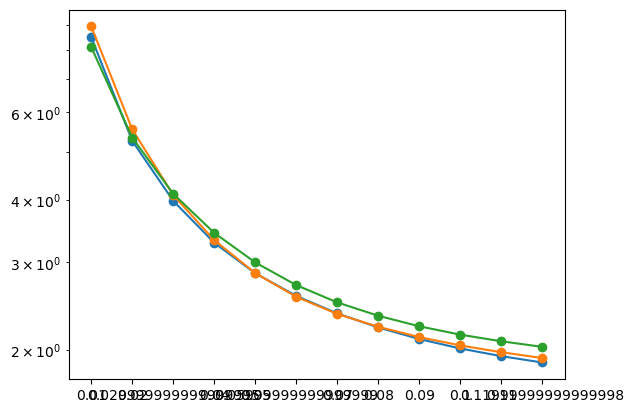

In [16]:
speeds = [0, 1000/45, 1000/30, 1000/20]
# for freq_idx in range(10):
    # plt.plot(speeds, [1, test_slow_std[freq_idx]/test_stationary_std[freq_idx], test_medium_std[freq_idx]/test_stationary_std[freq_idx], test_fast_std[freq_idx]/test_stationary_std[freq_idx]], 'o-')
plt.plot(np.arange(len(freq_arr)), test_fast_std/test_stationary_std, 'o-')
plt.plot(np.arange(len(freq_arr)), test_medium_std/test_stationary_std, 'o-')
plt.plot(np.arange(len(freq_arr)), test_slow_std/test_stationary_std, 'o-')
plt.xticks(np.arange(len(freq_arr)), freq_arr)
# plt.xscale('log')
plt.yscale('log')
plt.hlines(1, 0, len(freq_arr)-1, 'k', '--')
# plt.ylim(.9, 10)

In [17]:
# compute the responses of the optimal nonlinearities for each speed

num_samples = 10000
test_stimuli = np.random.laplace(0, 10, num_samples)

lambda_idx = 4

fast_responses = np.zeros((len(orientation_arr), len(phase_arr), len(wavelength_arr), len(position_arr), num_samples))
medium_responses = np.zeros((len(orientation_arr), len(phase_arr), len(wavelength_arr), len(position_arr), num_samples))
slow_responses = np.zeros((len(orientation_arr), len(phase_arr), len(wavelength_arr), len(position_arr), num_samples))
stationary_responses = np.zeros((len(orientation_arr), len(phase_arr), len(wavelength_arr), len(position_arr), num_samples))

for i, ori in enumerate(orientation_arr):
    for j, phase in enumerate(phase_arr):
        for k, freq in enumerate(freq_arr):
            for l, pos in enumerate(position_arr):
                # compute responses for each speed
                fast_responses[i, j, k, l] = logistic_func(test_stimuli, k=optimal_k_arr_fast[i, j, k, l, lambda_idx], L=optimal_L_arr_fast[i, j, k, l, lambda_idx])
                medium_responses[i, j, k, l] = logistic_func(test_stimuli, k=optimal_k_arr_medium[i, j, k, l, lambda_idx], L=optimal_L_arr_medium[i, j, k, l, lambda_idx])
                slow_responses[i, j, k, l] = logistic_func(test_stimuli, k=optimal_k_arr_slow[i, j, k, l, lambda_idx], L=optimal_L_arr_slow[i, j, k, l, lambda_idx])
                stationary_responses[i, j, k, l] = logistic_func(test_stimuli, k=optimal_k_arr_stationary[i, j, k, l, lambda_idx], L=optimal_L_arr_stationary[i, j, k, l, lambda_idx])

In [26]:
lambda_arr[lambda_idx]

1.0

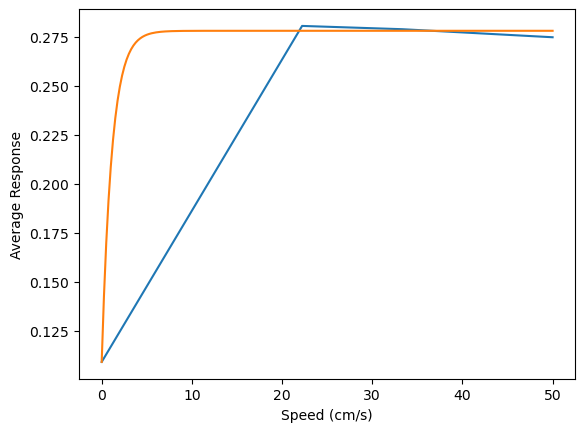

In [19]:
avg_fast_responses_per_filter = np.mean(fast_responses[:, :, :, :, :], axis=-1)
avg_medium_responses_per_filter = np.mean(medium_responses[:, :, :, :, :], axis=-1)
avg_slow_responses_per_filter = np.mean(slow_responses[:, :, :, :, :], axis=-1)
avg_stationary_responses_per_filter = np.mean(stationary_responses[:, :, :, :, :], axis=-1)
num_filters = len(avg_stationary_responses_per_filter.flatten())

# compute the average responses for each speed
avg_fast_responses = np.mean(avg_fast_responses_per_filter)
avg_medium_responses = np.mean(avg_medium_responses_per_filter)
avg_slow_responses = np.mean(avg_slow_responses_per_filter)
avg_stationary_responses = np.mean(avg_stationary_responses_per_filter)

# compute the SD
std_fast_responses = np.std(avg_fast_responses_per_filter)
std_medium_responses = np.std(avg_medium_responses_per_filter)
std_slow_responses = np.std(avg_slow_responses_per_filter)
std_stationary_responses = np.std(avg_stationary_responses_per_filter)

speeds = np.array([0, 1000/45, 1000/30, 1000/20])
avg_responses = [avg_stationary_responses, avg_slow_responses, avg_medium_responses, avg_fast_responses]
std_responses = [std_stationary_responses, std_slow_responses, std_medium_responses, std_fast_responses]

plt.plot(speeds, avg_responses) # 
# plt.fill_between(speeds, np.array(avg_responses) - np.array(std_responses), np.array(avg_responses) + np.array(std_responses), alpha=0.2)
plt.xlabel('Speed (cm/s)')
plt.ylabel('Average Response')

# fit an exponential function to the responses
from scipy.optimize import curve_fit

def exponential_func(x, a, b, c):
    return a-c*np.exp(b * x)

# format all data per filter to be fit
speeds = [[0]*num_filters, [1000/45]*num_filters, [1000/30]*num_filters, [1000/20]*num_filters]
speeds = np.array(speeds).flatten()
avg_responses = np.concatenate((avg_stationary_responses_per_filter.flatten(), avg_slow_responses_per_filter.flatten(), avg_medium_responses_per_filter.flatten(), avg_fast_responses_per_filter.flatten()))

popt, pcov = curve_fit(exponential_func, speeds, avg_responses, p0=[.9, -.01, .3], maxfev=int(1e6), ftol=1e-8)

plt.plot(np.linspace(0, 50, 200), exponential_func(np.linspace(0, 50, 200), *popt))

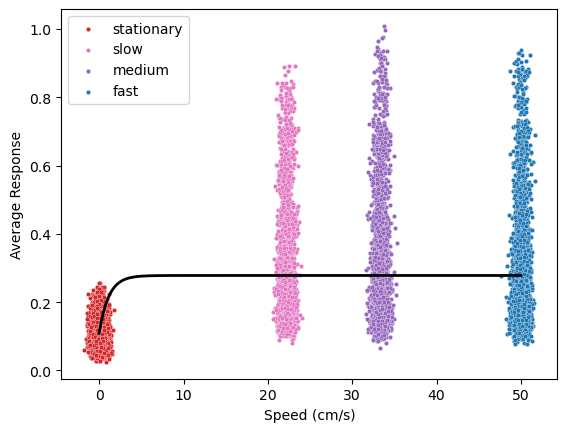

In [20]:
jitter_sigma_x = .5
jitter_sigma_y = .01
num_filters = len(avg_stationary_responses_per_filter.flatten())
plt.scatter([0]*num_filters+np.random.normal(0, jitter_sigma_x, num_filters), avg_stationary_responses_per_filter.flatten()+np.random.normal(0, jitter_sigma_y, num_filters), s=10, color='tab:red', label='stationary', edgecolor='w', linewidth=.2)
plt.scatter([1000/45]*num_filters+np.random.normal(0, jitter_sigma_x, num_filters), avg_slow_responses_per_filter.flatten()+np.random.normal(0, jitter_sigma_y, num_filters), s=10, color='tab:pink', label='slow', edgecolor='w', linewidth=.2)
plt.scatter([1000/30]*num_filters+np.random.normal(0, jitter_sigma_x, num_filters), avg_medium_responses_per_filter.flatten()+np.random.normal(0, jitter_sigma_y, num_filters), s=10, color='tab:purple', label='medium', edgecolor='w', linewidth=.2)
plt.scatter([1000/20]*num_filters+np.random.normal(0, jitter_sigma_x, num_filters), avg_fast_responses_per_filter.flatten()+np.random.normal(0, jitter_sigma_y, num_filters), s=10, color='tab:blue', label='fast', edgecolor='w', linewidth=.2)
plt.plot(np.linspace(0, 50, 200), exponential_func(np.linspace(0, 50, 200), *popt), color='k', linewidth=2)
plt.xlabel('Speed (cm/s)')
plt.ylabel('Average Response')
plt.legend()
plt.savefig('../manuscript_figures/speed_tuning.pdf', bbox_inches='tight', format='pdf')

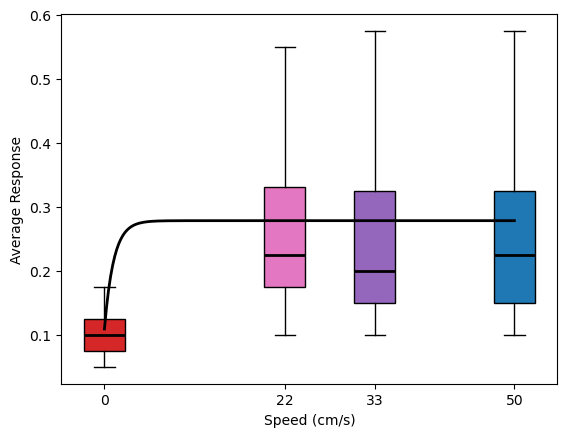

In [21]:
speeds = np.round(np.array([0, 1000/45, 1000/30, 1000/20])).astype(int)
colors = ['tab:red', 'tab:pink', 'tab:purple', 'tab:blue']
bplot = plt.boxplot([avg_stationary_responses_per_filter.flatten(), avg_slow_responses_per_filter.flatten(), avg_medium_responses_per_filter.flatten(), avg_fast_responses_per_filter.flatten()], positions=speeds, showfliers=False, patch_artist=True, widths=5, medianprops={'color': 'k', 'linewidth': 2})
for patch, color in zip(bplot['boxes'], colors):
    patch.set_facecolor(color)
plt.plot(np.linspace(0, 50, 200), exponential_func(np.linspace(0, 50, 200), *popt), color='k', linewidth=2)
plt.xlabel('Speed (cm/s)')
plt.ylabel('Average Response')
# plt.legend()
plt.savefig('../manuscript_figures/speed_tuning_box_plot.pdf', bbox_inches='tight', format='pdf')

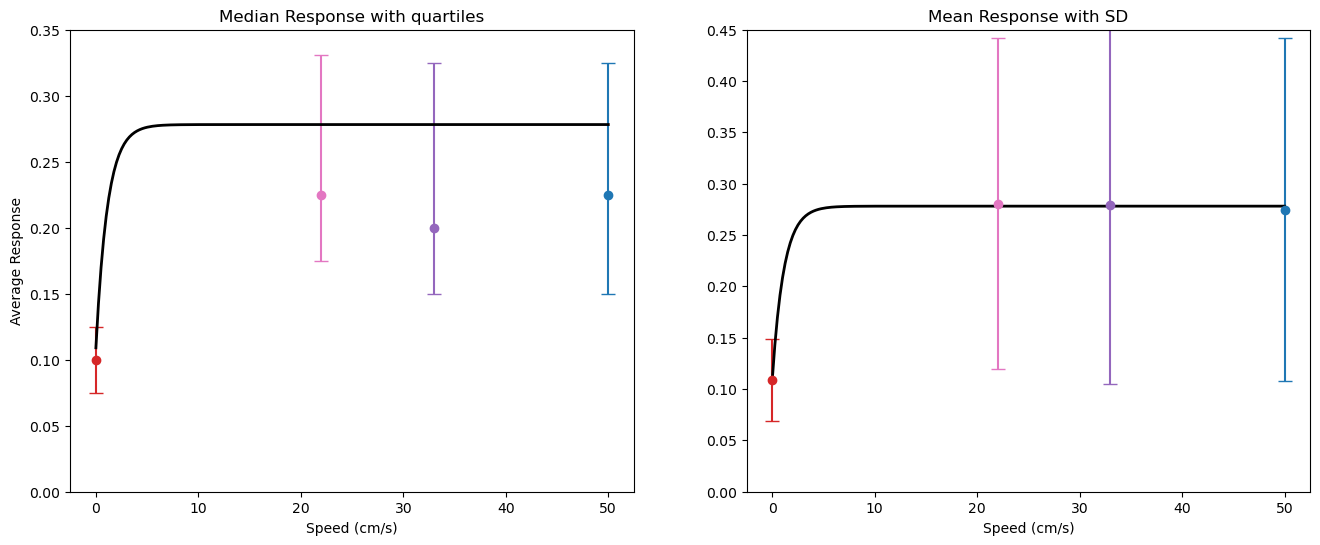

In [22]:
# ax2.errorbar(high_freq_bins, high_freq_median, yerr=[high_freq_median - high_freq_25th, high_freq_75th - high_freq_median], color='tab:pink', ecolor='k', capsize=5, linestyle='', fmt='o')

stationary_median = np.median(avg_stationary_responses_per_filter.flatten())
stationary_mean = np.mean(avg_stationary_responses_per_filter.flatten())
slow_median = np.median(avg_slow_responses_per_filter.flatten())
slow_mean = np.mean(avg_slow_responses_per_filter.flatten())
medium_median = np.median(avg_medium_responses_per_filter.flatten())
medium_mean = np.mean(avg_medium_responses_per_filter.flatten())
fast_median = np.median(avg_fast_responses_per_filter.flatten())
fast_mean = np.mean(avg_fast_responses_per_filter.flatten())
stationary_25th = np.percentile(avg_stationary_responses_per_filter.flatten(), 25)
stationary_75th = np.percentile(avg_stationary_responses_per_filter.flatten(), 75)
slow_25th = np.percentile(avg_slow_responses_per_filter.flatten(), 25)
slow_75th = np.percentile(avg_slow_responses_per_filter.flatten(), 75)
medium_25th = np.percentile(avg_medium_responses_per_filter.flatten(), 25)
medium_75th = np.percentile(avg_medium_responses_per_filter.flatten(), 75)
fast_25th = np.percentile(avg_fast_responses_per_filter.flatten(), 25)
fast_75th = np.percentile(avg_fast_responses_per_filter.flatten(), 75)
stationary_sd = np.std(avg_stationary_responses_per_filter.flatten())
slow_sd = np.std(avg_slow_responses_per_filter.flatten())
medium_sd = np.std(avg_medium_responses_per_filter.flatten())
fast_sd = np.std(avg_fast_responses_per_filter.flatten())

median_responses = np.array([stationary_median, slow_median, medium_median, fast_median])
mean_responses = np.array([stationary_mean, slow_mean, medium_mean, fast_mean])
response_sd = np.array([stationary_sd, slow_sd, medium_sd, fast_sd])
responses_25th = np.array([stationary_25th, slow_25th, medium_25th, fast_25th])
responses_75th = np.array([stationary_75th, slow_75th, medium_75th, fast_75th])

speeds = np.round(np.array([0, 1000/45, 1000/30, 1000/20])).astype(int)
colors = ['tab:red', 'tab:pink', 'tab:purple', 'tab:blue']
fig, ax = plt.subplots(1, 2, figsize=(16,6))
for i in range(len(colors)):
    ax[0].errorbar(speeds[i], median_responses[i], yerr=[[median_responses[i]-responses_25th[i]], [responses_75th[i]-median_responses[i]]], fmt='o', color=colors[i], capsize=5)
    ax[1].errorbar(speeds[i], mean_responses[i], yerr=response_sd[i], fmt='o', color=colors[i], capsize=5)
# plt.errorbar(speeds, median_responses, yerr=[median_responses-responses_25th, responses_75th-median_responses], fmt='o', color=colors, capsize=5)
ax[0].plot(np.linspace(0, 50, 200), exponential_func(np.linspace(0, 50, 200), *popt), color='k', linewidth=2)
ax[1].plot(np.linspace(0, 50, 200), exponential_func(np.linspace(0, 50, 200), *popt), color='k', linewidth=2)
ax[0].set_xlabel('Speed (cm/s)')
ax[1].set_xlabel('Speed (cm/s)')
ax[0].set_ylabel('Average Response')
ax[0].set_ylim(0,.35)
ax[1].set_ylim(0,.45)
ax[0].set_title('Median Response with quartiles')
ax[1].set_title('Mean Response with SD')
# plt.legend()
plt.savefig('../manuscript_figures/speed_tuning_scatter_with_error.pdf', bbox_inches='tight', format='pdf')

In [23]:
# compute the norm factor as the max for each speed
norm_factor = np.max([np.max(avg_stationary_responses_per_filter), np.max(avg_slow_responses_per_filter), np.max(avg_medium_responses_per_filter), np.max(avg_fast_responses_per_filter)])
norm_factor

0.9995801960065345

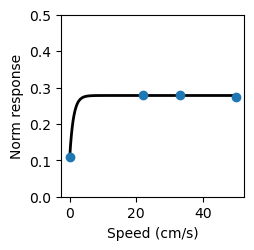

In [25]:
cm = 1/2.54
fig, ax = plt.subplots(1, 1, figsize=(6*cm,6*cm))
# plt.errorbar(speeds, median_responses, yerr=[median_responses-responses_25th, responses_75th-median_responses], fmt='o', color=colors, capsize=5)
ax.plot(np.linspace(0, 50, 200), exponential_func(np.linspace(0, 50, 200), *popt)/norm_factor, color='k', linewidth=2)
ax.plot(speeds, mean_responses/norm_factor, 'o')
ax.set_xlabel('Speed (cm/s)')
ax.set_ylabel('Norm response')
ax.set_ylim(0, 0.5)
# plt.legend()
plt.savefig('../manuscript_figures/fig2_speed_tuning_fit.pdf', bbox_inches='tight', format='pdf')